## Inference Analysis

In this notebook we're looking at the statistical significance of distribution differences between weather features and the extent of traffic delay severity caused by an accident.  The original data had four rankings of severity, which will be reduced to two, 0 = low and 1 = high.

In [33]:
import pandas as pd

# Import Data
train = pd.read_csv('C:/data/Accidents.csv')

# Reduce traffic Severity from four categories down to two
train['Severity01'] = train['Severity'].apply(lambda x: 1 if x >= 3 else 0)
train['SeverityLoHi'] = train['Severity'].apply(lambda x: "High" if x >= 3 else "Low")

high = train.loc[train.Severity01 == 1,:].copy()
low = train.loc[train.Severity01 == 0,:].copy()


In [34]:
print("Records: ", len(train))
print("High Severity: ", round(len(high) / len(train),2))
print("Low Severity: ", round(len(low)/len(train),2))

Records:  2717404
High Severity:  0.32
Low Severity:  0.68


In [35]:
# Correlation of Weather Metrics
cols = ['Severity01', 'Duration(m)', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
train[cols].corr().round(3)

,Severity01,Duration(m),Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
Severity01,1.000,-0.034,0.117,-0.016,-0.021,0.018,0.039,-0.015,0.029,0.026
Duration(m),-0.034,1.000,0.260,0.004,-0.017,-0.029,0.018,0.016,0.038,0.031
Distance(mi),0.117,0.260,1.000,-0.054,-0.051,0.019,0.007,-0.011,0.030,0.022
Temperature(F),-0.016,0.004,-0.054,1.000,0.834,-0.326,-0.207,0.212,0.004,0.057
Wind_Chill(F),-0.021,-0.017,-0.051,0.834,1.000,-0.139,-0.273,0.155,-0.111,0.039
Humidity(%),0.018,-0.029,0.019,-0.326,-0.139,1.000,0.034,-0.411,-0.156,0.105
Pressure(in),0.039,0.018,0.007,-0.207,-0.273,0.034,1.000,0.036,-0.010,0.056
Visibility(mi),-0.015,0.016,-0.011,0.212,0.155,-0.411,0.036,1.000,0.028,-0.124
Wind_Speed(mph),0.029,0.038,0.030,0.004,-0.111,-0.156,-0.010,0.028,1.000,0.035
Precipitation(in),0.026,0.031,0.022,0.057,0.039,0.105,0.056,-0.124,0.035,1.000


Initially, it is disappointing to see little-to-no correlation between Accident Traffic Severity and weather conditions.  A minor correlation between Severity and Distance in miles is present.

Between the weather conditions, distance and duration:
There is only one observed strong correlation between Temperature and Wind Chill.  This might imply Wind Chill will be a redundant feature.

A moderate, negative correlation between Visibility and Humidity, as increased humidity can create foggy driving conditions. Interestingly, Temperature and Humidity are also negatively correlated. According to online sources, as air temperature increases, air can hold more water vapor, and its relative humidity decreases.

Duration and Distance of traffic have a low correlation together of 0.26. Surprisingly, Temperature alone, which could indicate freezing conditions, does not correlate to Duration or Distance of traffic accidents. There are no weather metrics with clear correlation to accident severity, duration, or distance.

In [90]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Seed Random
np.random.seed(7)

# Set default for figure sizes
mpl.rcParams['figure.figsize'] = (16,6)

# Define common statistical support functions

# Comparison Function Difference of Means
def mean_diff(data1, data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Permutation Sample Function
def permutation_sample(data1, data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1, data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1, perm_sample_2)

# Generate Permutation Replicates
def draw_perm_reps(data1, data2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data1, data2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
        
    return perm_replicates

# Generate Subsample
def sub_sample_mean(data, size=1000, count=100):
    sub_sample = np.empty(count)
    for i in range(count):
        sub_sample_each = data.sample(n=size)
        sub_sample[i] = np.mean(sub_sample_each)
        
    return sub_sample

# Empirical Cumulative Distribution Function
def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

# p-values, confidence intervals, margin of error
def test_mean_diff(data1, data2, mean_diff_val, count, h0_diff=0):
    perm_replicates = draw_perm_reps(data1, data2, mean_diff, count)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates,bins=25,color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(high)=p(low)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(high)=p(low)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

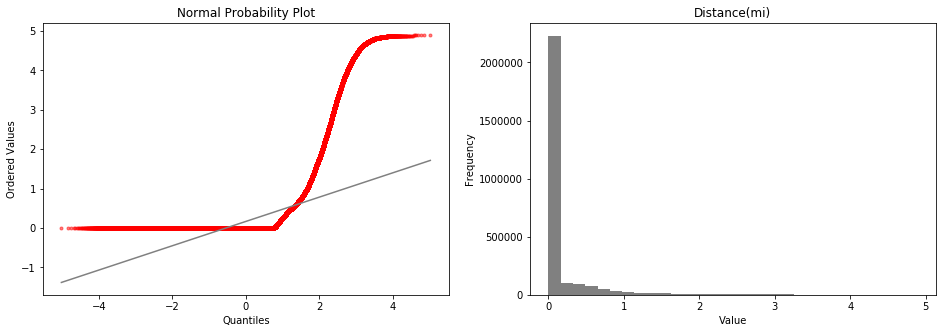

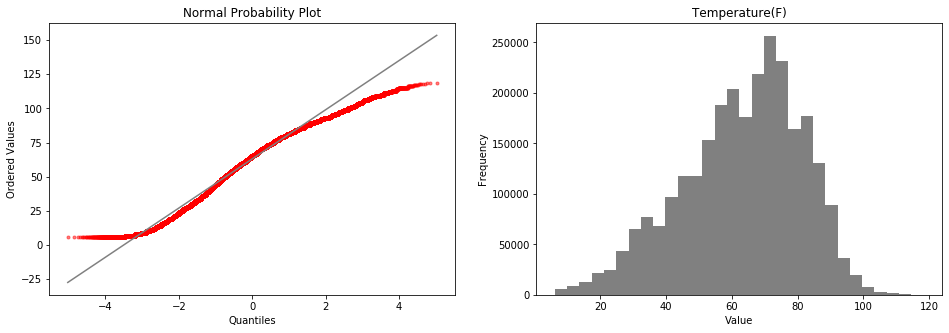

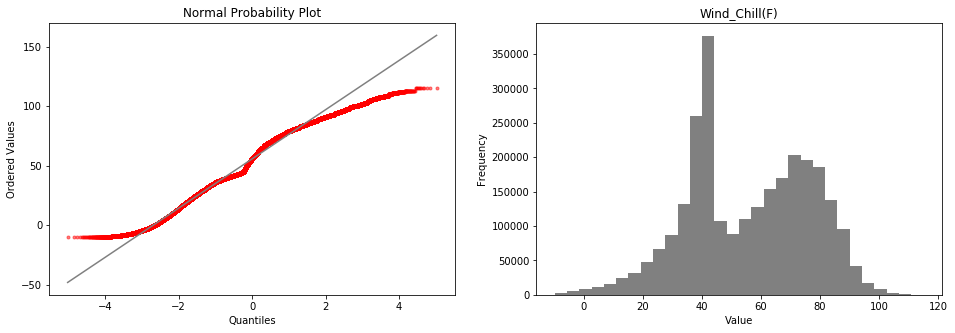

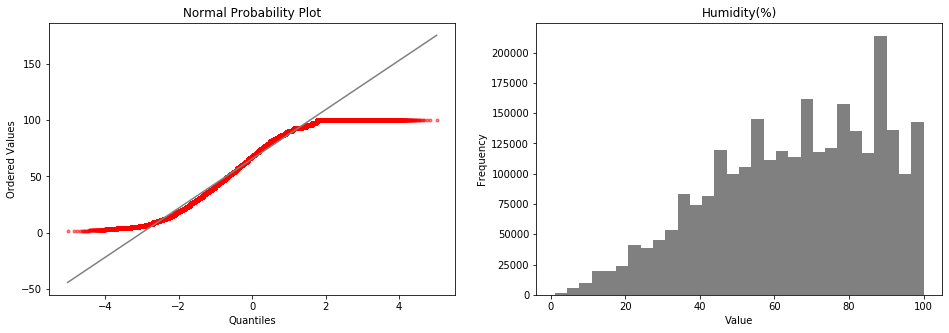

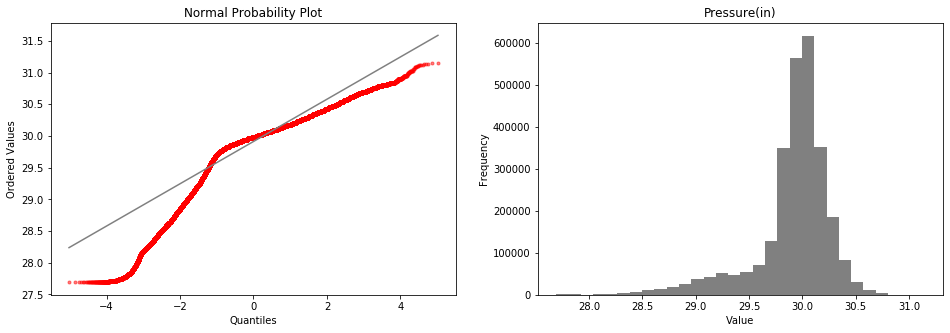

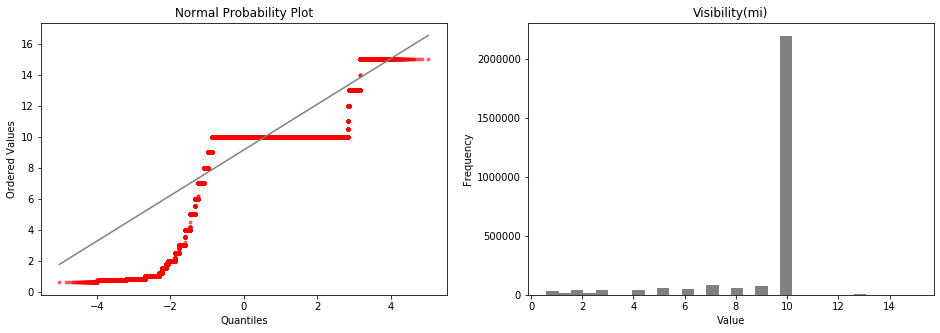

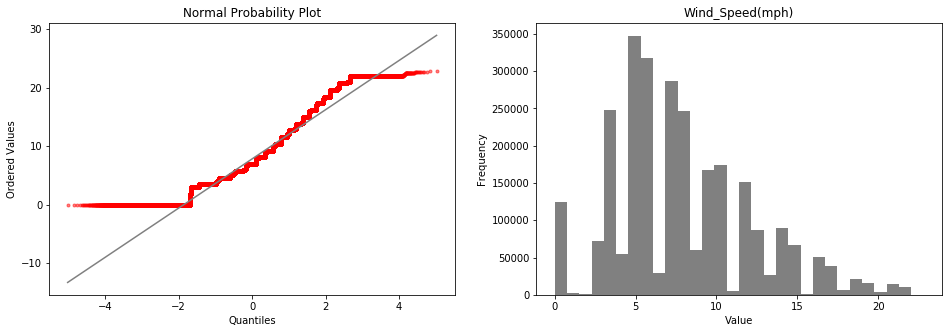

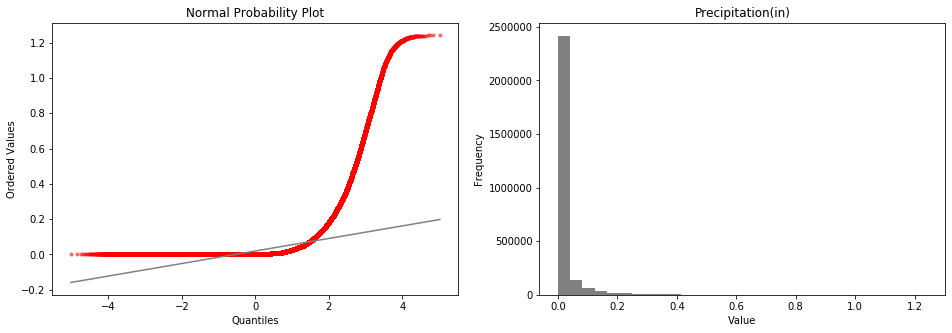

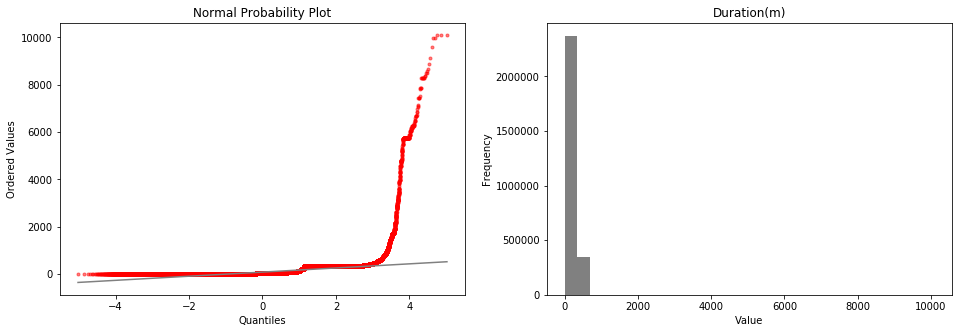

In [4]:
# QQ plot per feature
import scipy.stats as stats

def lreg_line(slope,intercept,test_data):
    x_lreg = np.array([min(test_data),max(test_data)])
    y_lreg = slope * x_lreg + intercept
    return x_lreg,y_lreg
        
def qq_plot(data):
    data_no_na = data.dropna()
    fig, ax = plt.subplots(1,2,figsize=(16, 5))
    _ = plt.subplot(1,2,1)
    (x,y), (slope,intercept,r) = stats.probplot(data_no_na, dist="norm", plot=None)
    _ = plt.plot(x,y,marker='.',linestyle='none',color='red',alpha=0.5)
    x_lreg,y_lreg = lreg_line(slope,intercept,x)
    _ = plt.plot(x_lreg,y_lreg,color='gray')
    _ = plt.xlabel('Quantiles')
    _ = plt.ylabel('Ordered Values')
    _ = plt.title('Normal Probability Plot')
    _ = plt.subplot(1,2,2)
    _ = plt.hist(data_no_na, color='gray',bins=30)
    _ = plt.xlabel('Value')
    _ = plt.ylabel('Frequency')

features = ['Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Duration(m)']

for feature in features:
    qq_plot(train[feature])
    plt.title(feature)

Unfortunately, we are not dealing with normal distributions in this case.  I will use the mean difference with permutations in the following plots for Temperature, Wind Chill, Humidity, Pressure, and Wind Speed.

There are several very skewed features that may have a default setting.  Distance and Precipitation will be changed to a binary category representing zero, not zero and Visibility is ten, not ten (miles).  

Duration in minutes, heavily skewed, does range up to 10,000, but clusters with various seconds around 29-30 minutes.    

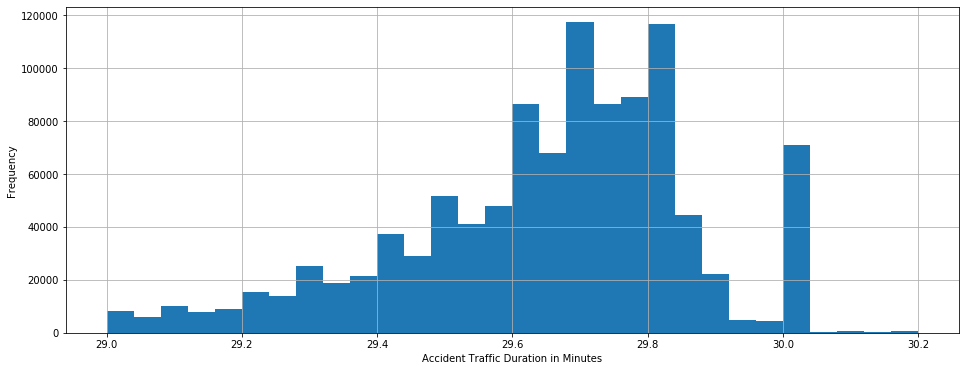

In [8]:
train['Duration(m)'][(train['Duration(m)'] >= 29) & (train['Duration(m)'] <=30.2)].hist(bins=30)
plt.xlabel("Accident Traffic Duration in Minutes")
plt.ylabel("Frequency")
plt.show()

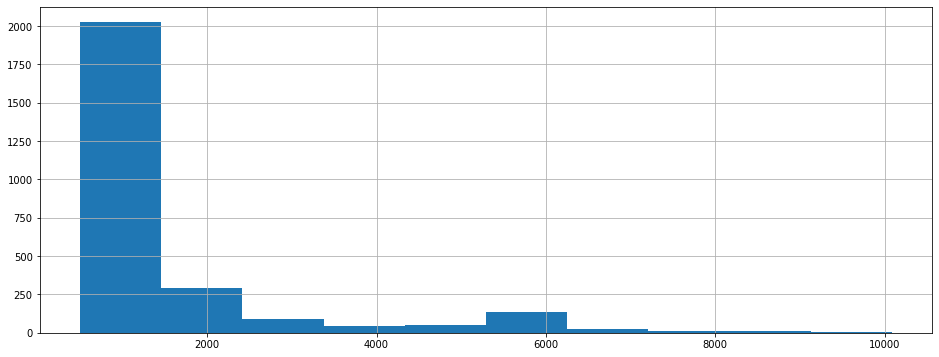

In [44]:
train['Duration(m)'][train['Duration(m)'] >= 500].hist()

In [36]:
# Features with high percentage at default setting

print("Distance = 0: ", train['Distance(mi)'][train['Distance(mi)'] ==0].count(), round(train['Distance(mi)'][train['Distance(mi)'] ==0].count()/ len(train),2))
print("Precipitation = 0: ", train['Precipitation(in)'][train['Precipitation(in)'] ==0].count(), round(train['Precipitation(in)'][train['Precipitation(in)'] ==0].count()/ len(train),2))
print("Visibility = 10: ", train['Visibility(mi)'][train['Visibility(mi)'] == 10].count(), round(train['Visibility(mi)'][train['Visibility(mi)'] ==10].count()/ len(train),2))

Distance = 0:  1856856 0.68
Precipitation = 0:  1656376 0.61
Visibility = 10:  2196242 0.81


In [37]:
# Change defaulting features into binary columns

train['DistanceZero'] = train['Distance(mi)'].apply(lambda x: 1 if x == 0 else 0)
train['PrecipitationZero'] = train['Precipitation(in)'].apply(lambda x: 1 if x == 0 else 0)
train['VisibilityTen'] = train['Distance(mi)'].apply(lambda x: 1 if x == 10 else 0)

## Compare Means of High Accident Traffic Severity vs. Low Across Weather Metrics

## Temperature Distribution (Fahrenheit)

    H0: The Temperature(F) Distribution for High and Low Accident Traffic Severity is the same (i.e. the mean diff is 0).   
    H1: The Temperature(F) Distribution for High and Low Accident Traffic Severity is not the same.
    alpha = 0.05

High Severity Temp Mean: 62.631576185300524
Low Severity Temp Mean: 63.253038855079296
Mean Diff: -0.6214626697787722
H0 Diff: 0


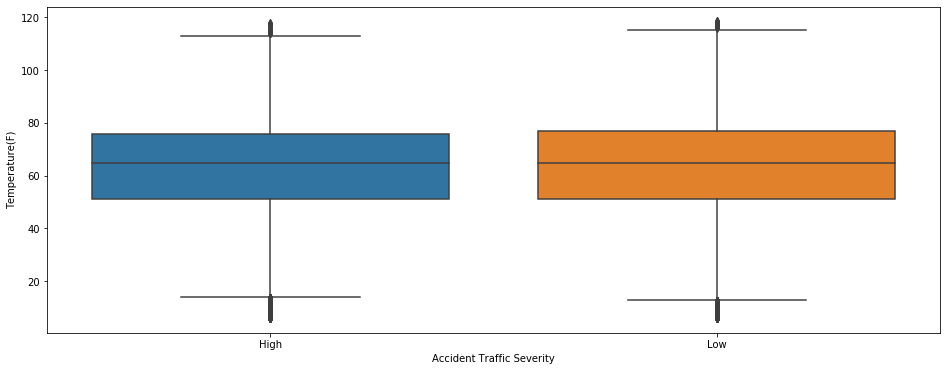

p: 0.0
CI: [-0.05213991  0.04192216]
ME: 0.045188565274005346


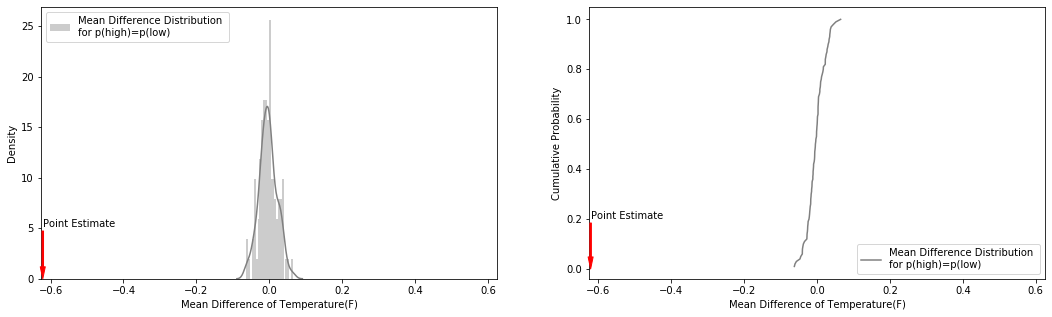

In [39]:
high_temperature = high['Temperature(F)'].dropna()
low_temperature = low['Temperature(F)'].dropna()

high_low_diff = high_temperature.mean() - low_temperature.mean()
h0_diff = 0
print("High Severity Temp Mean: {}\nLow Severity Temp Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_temperature.mean(), low_temperature.mean(), high_low_diff, h0_diff))

sns.boxplot(x='SeverityLoHi', y='Temperature(F)', data=train)
plt.xlabel('Accident Traffic Severity')
plt.show()

test_mean_diff(high_temperature, low_temperature, high_low_diff, 100)

The mean differences between High and Low are small and the confidence interval contains zero.  I would expect to accept the null hypothesis, yet the p-value is zero.  There may be a very mild effect because the means are not identical or the dataset is so large it will always detect statistical significance.  Run a two-sample t-test.

In [54]:
# Additional two-sample t-test
from scipy import stats
print("high severity Temperature variance ", round(high['Temperature(F)'].var(),2))
print("low severity Temperature variance ", round(low['Temperature(F)'].var(),2))
stats.ttest_ind(high['Temperature(F)'], low['Temperature(F)'])

high severity Temperature variance  330.23
low severity Temperature variance  329.43


Ttest_indResult(statistic=-26.404206685732284, pvalue=1.2821624720799535e-153)

Again, the p-value is essentially zero and fails to accept the null hypothesis that there is no difference between temperature means of High and Low severity accident traffic.  Generate small sub-samples.

In [83]:
high_temp_sub = sub_sample_mean(high['Temperature(F)'])
low_temp_sub = sub_sample_mean(low['Temperature(F)'])
stats.ttest_ind(high_temp_sub, low_temp_sub)    

Ttest_indResult(statistic=-8.194750844748631, pvalue=3.0805709694929375e-14)

In [94]:
len(high_temp_sub)

100

Taking the mean of 1,000 records at a time, 100 times each of High vs. Low severity, and we continue to reject the Null Hypothesis.

## Wind Chill Distribution (F)

High Severity Wind Chill Mean: 55.097404331308965
Low Severity Wind Chill Mean: 56.03127442936648
Mean Diff: -0.9338700980575183
H0 Diff: 0


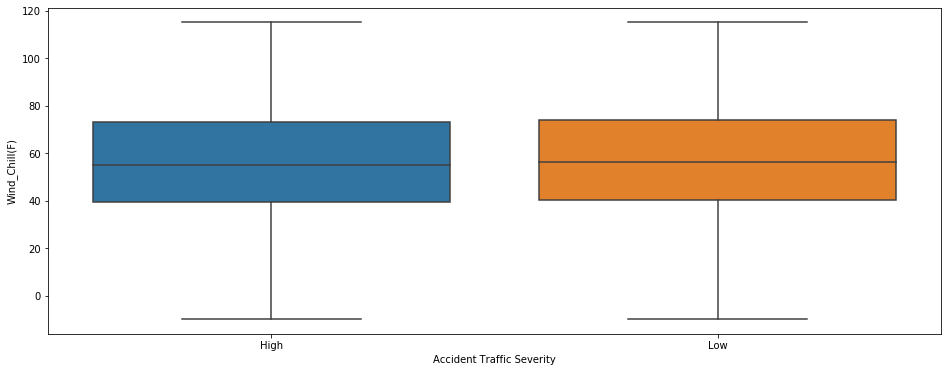

p: 0.0
CI: [-0.05456964  0.05481829]
ME: 0.05610367266122199


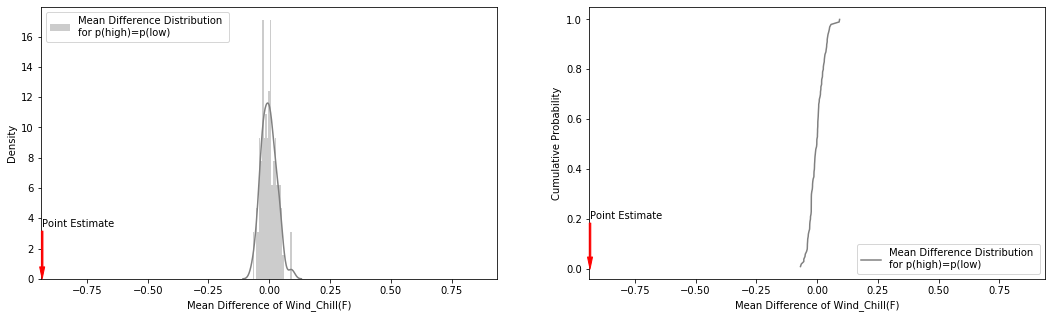

In [85]:
high_wind_chill = high['Wind_Chill(F)'].dropna()
low_wind_chill = low['Wind_Chill(F)'].dropna()

high_low_diff = high_wind_chill.mean() - low_wind_chill.mean()
h0_diff = 0
print("High Severity Wind Chill Mean: {}\nLow Severity Wind Chill Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_wind_chill.mean(), low_wind_chill.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi', y='Wind_Chill(F)', data=train)
plt.xlabel('Accident Traffic Severity')
plt.show()

test_mean_diff(high_wind_chill, low_wind_chill, high_low_diff, 100)

The same outcome as Temperature, which would be expected considering their high correlation.

## Pressure Distribution (in)

High Severity Pressure Mean: 29.932684963998195
Low Severity Pressure Mean: 29.90275656117535
Mean Diff: 0.02992840282284348
H0 Diff: 0


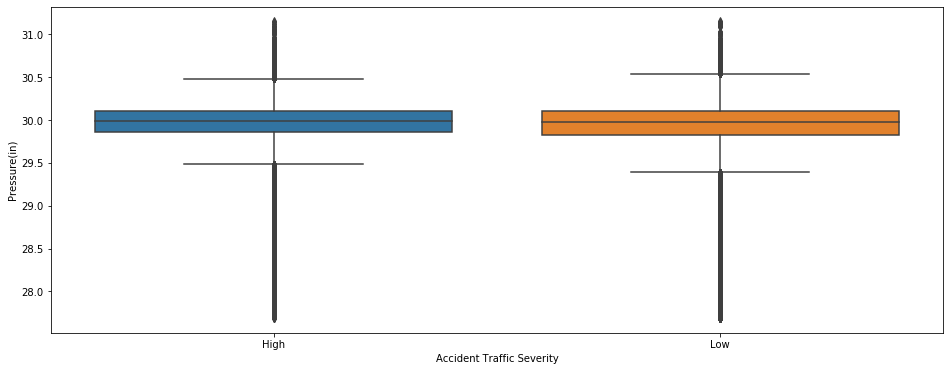

p: 0.0
CI: [-0.00118464  0.0008306 ]
ME: 0.0008792717363011521


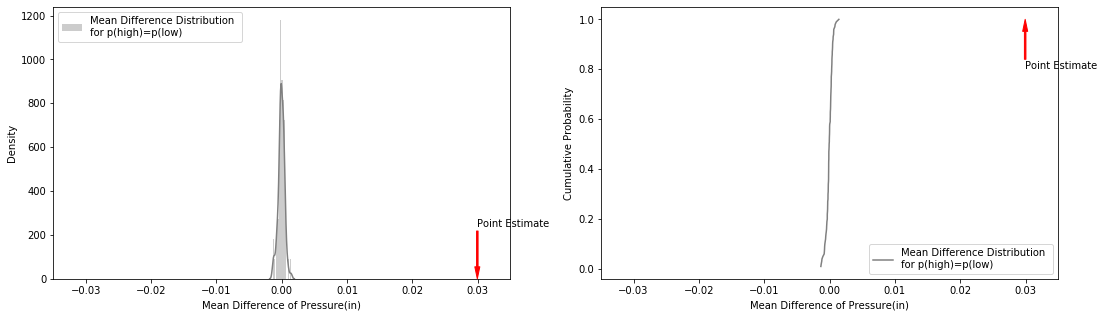

In [86]:
high_pressure = high['Pressure(in)'].dropna()
low_pressure = low['Pressure(in)'].dropna()

high_low_diff = high_pressure.mean() - low_pressure.mean()
h0_diff = 0
print("High Severity Pressure Mean: {}\nLow Severity Pressure Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_pressure.mean(), low_pressure.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi', y='Pressure(in)', data=train)
plt.xlabel('Accident Traffic Severity')
plt.show()

test_mean_diff(high_pressure, low_pressure, high_low_diff, 100)

Pressure appears to have no distinction between the two categories.  I would like to have a p-value fail to reject the null hypothesis that the means are the same, but practical indicators suggests the means are very similar.

In [91]:
high_press_sub = sub_sample_mean(high['Pressure(in)'])
low_press_sub = sub_sample_mean(low['Pressure(in)'])
stats.ttest_ind(high_press_sub, low_press_sub)    

Ttest_indResult(statistic=18.819035517303647, pvalue=5.6756471019481944e-46)

In [93]:
len(high_press_sub)

100

## Distance Distribution (of traffic in miles)

High Severity Distance Mean: 0.2512084166855638
Low Severity Distance Mean: 0.12522722810616832
Mean Diff: 0.1259811885793955
H0 Diff: 0


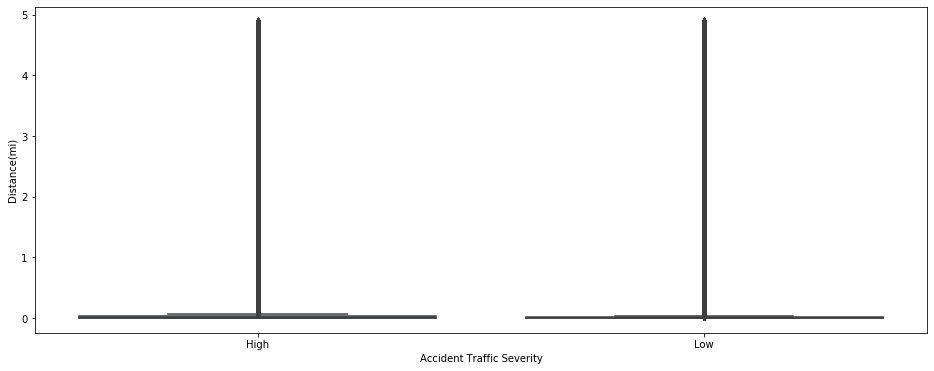

p: 0.0
CI: [-0.00105993  0.00110911]
ME: 0.0011201982536920897


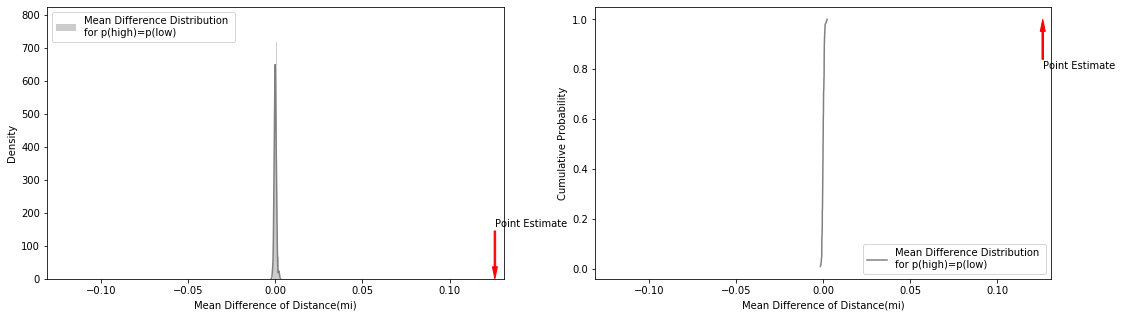

In [95]:
high_distance = high['Distance(mi)'].dropna()
low_distance = low['Distance(mi)'].dropna()

high_low_diff = high_distance.mean() - low_distance.mean()
h0_diff = 0
print("High Severity Distance Mean: {}\nLow Severity Distance Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_distance.mean(), low_distance.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi', y='Distance(mi)', data=train)
plt.xlabel('Accident Traffic Severity')
plt.show()

test_mean_diff(high_distance, low_distance, high_low_diff, 100)

I see the mean distance of High Severity accident traffic is twice as large as Low Severity.  I apply Windsorizing to avoid outliers and it retains the difference in means.

In [103]:
from scipy.stats.mstats import winsorize
high_distance_w = winsorize(high_distance, limits=[0.1, 0.1])
low_distance_w = winsorize(low_distance, limits=[0.1, 0.1])
high_low_diff = high_distance_w.mean() - low_distance_w.mean()
h0_diff = 0
print("High Severity Distance Mean: {}\nLow Severity Distance Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_distance_w.mean(), low_distance_w.mean(), high_low_diff,h0_diff))

High Severity Distance Mean: 0.14201143525515877
Low Severity Distance Mean: 0.06472388298910384
Mean Diff: 0.07728755226605494
H0 Diff: 0


Two sample T test with small sub samples.

In [104]:
high_dist_sub = sub_sample_mean(high['Distance(mi)'])
low_dist_sub = sub_sample_mean(low['Distance(mi)'])a
stats.ttest_ind(high_dist_sub, low_dist_sub)    

Ttest_indResult(statistic=50.51564331882517, pvalue=4.443135065335543e-115)

## Wind Speed Distribution (mph)

High Severity Wind Speed Mean: 7.999216873394668
Low Severity Wind Speed Mean: 7.7370550303059735
Mean Diff: 0.2621618430886947
H0 Diff: 0


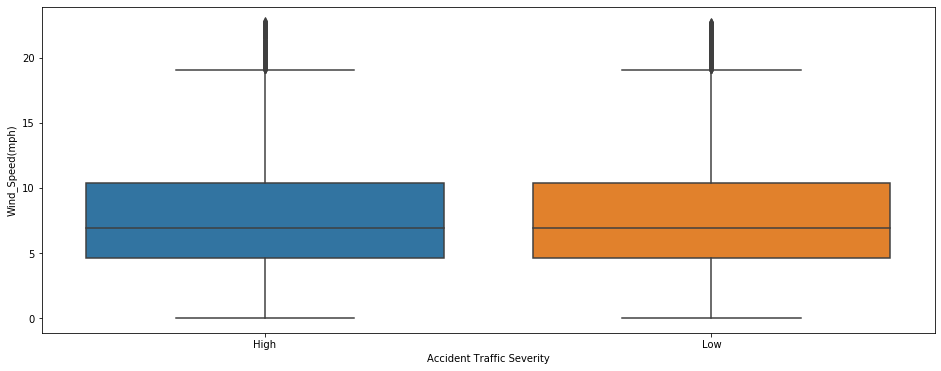

p: 0.0
CI: [-0.010453    0.01283511]
ME: 0.01204597455758505


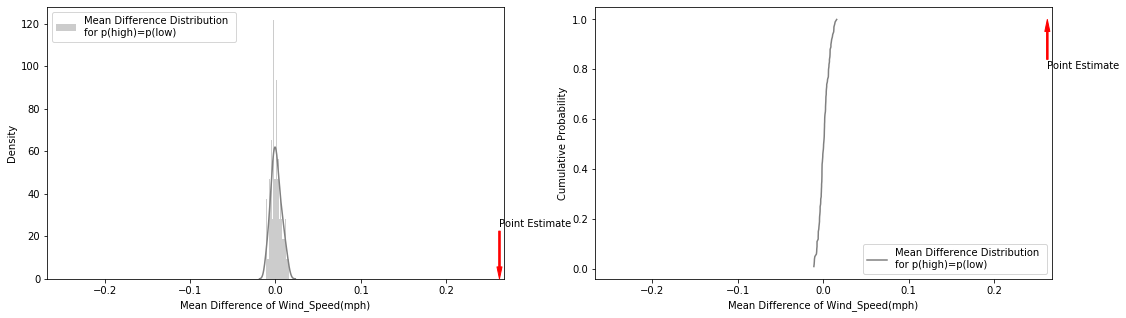

In [106]:
high_wind_speed = high['Wind_Speed(mph)'].dropna()
low_wind_speed = low['Wind_Speed(mph)'].dropna()

high_low_diff = high_wind_speed.mean() - low_wind_speed.mean()
h0_diff = 0
print("High Severity Wind Speed Mean: {}\nLow Severity Wind Speed Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_wind_speed.mean(), low_wind_speed.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi', y='Wind_Speed(mph)', data=train)
plt.xlabel('Accident Traffic Severity')
plt.show()

test_mean_diff(high_wind_speed, low_wind_speed, high_low_diff, 100)

## Humidity Distribution (%)

High Severity Humidity Mean: 66.08772904320682
Low Severity Humidity Mean: 65.21196348289683
Mean Diff: 0.8757655603099863
H0 Diff: 0


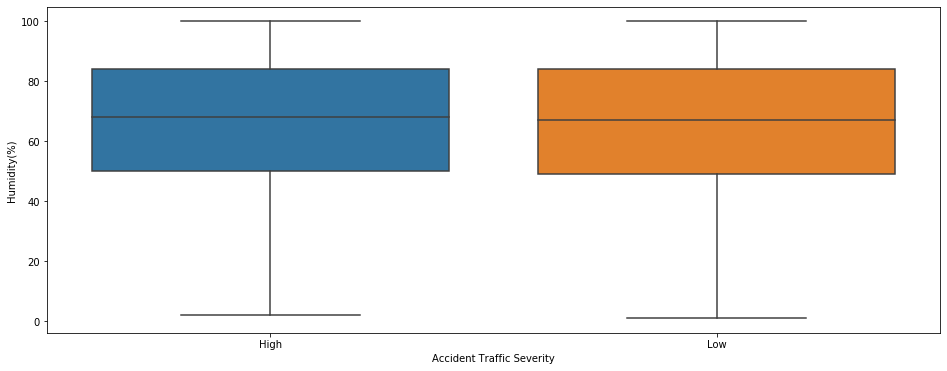

p: 0.0
CI: [-0.04073983  0.04878131]
ME: 0.043931745800655855


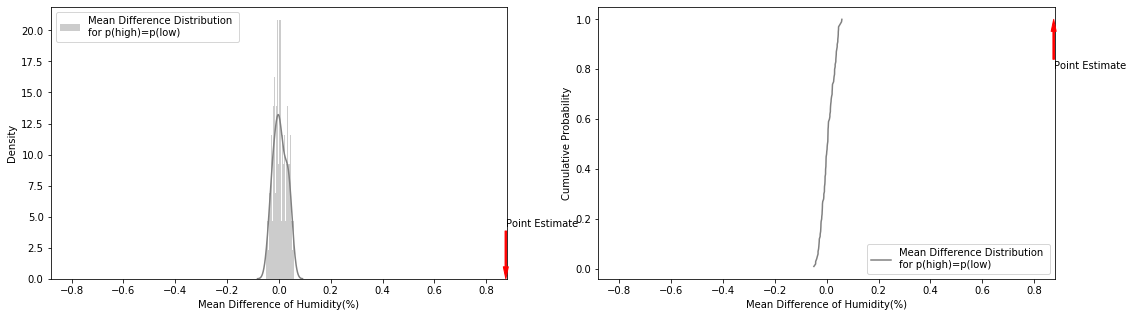

In [107]:
high_humidity = high['Humidity(%)'].dropna()
low_humidity = low['Humidity(%)'].dropna()

high_low_diff = high_humidity.mean() - low_humidity.mean()
h0_diff = 0
print("High Severity Humidity Mean: {}\nLow Severity Humidity Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(high_humidity.mean(), low_humidity.mean(), high_low_diff,h0_diff))

sns.boxplot(x='SeverityLoHi', y='Humidity(%)', data=train)
plt.xlabel('Accident Traffic Severity')
plt.show()

test_mean_diff(high_humidity, low_humidity, high_low_diff, 100)

The weather features recorded during accidents do not appear to have a significant impact on the severity of traffic.  The difference of means between high and low severity have very narrow distributions around zero.  Due to possible record size, the p-values never accepted the null hypothesis that the means were equal.